In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
!pip install -q transformers torch sentencepiece underthesea openpyxl

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from underthesea import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Reshape, Input, Embedding, Conv2D, MaxPool2D, Flatten, Concatenate, Dropout, Dense,
    Bidirectional, GRU, GlobalMaxPooling1D
)
from tensorflow.keras.models import Model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import itertools

In [ ]:
df_train = pd.read_csv('/content/df_train_clean.csv')
df_dev   = pd.read_csv('/content/df_dev_clean.csv')
df_test  = pd.read_csv('/content/df_test_clean.csv')

In [ ]:
texts_train, y_train = df_train['content_clean'].fillna('').tolist(), df_train['Toxicity'].tolist()
texts_dev,   y_dev   = df_dev['content_clean'].fillna('').tolist(),   df_dev['Toxicity'].tolist()
texts_test,  y_test  = df_test['content_clean'].fillna('').tolist(),  df_test['Toxicity'].tolist()

In [ ]:
emo_df = pd.read_excel('/content/VnEmoLex.xlsx')
print(emo_df.columns)

Index(['Unnamed: 0', 'Vietnamese', 'Positive', 'Negative',
       'Anger\n/ tức giận', 'Anticipation\n/ Hi vọng',
       'Disgust\n/ chán ghét', 'Fear\n/ sợ hãi', 'Joy\n/ thích thú',
       'Sadness\n/ buồn bã', 'Surprise\n/ ngạc nhiên',
       'Trust\n/ tin tưởng', 'Unnamed: 12'],
      dtype='object')


In [ ]:
toxic_emotions = [
    'Anger\n/ tức giận',
    'Disgust\n/ chán ghét',
    'Fear\n/ sợ hãi',
    'Sadness\n/ buồn bã',
    'Negative'
]
non_toxic_emotions = [
    'Joy\n/ thích thú',
    'Trust\n/ tin tưởng',
    'Anticipation\n/ Hi vọng',
    'Surprise\n/ ngạc nhiên',
    'Positive'
]

In [ ]:
is_toxic = (
    emo_df[toxic_emotions].fillna(0).astype(int).any(axis=1) |
    (emo_df['Negative'].fillna(0).astype(int) == 1)
)

is_non_toxic = (
    emo_df[non_toxic_emotions].fillna(0).astype(int).any(axis=1) |
    (emo_df['Positive'].fillna(0).astype(int) == 1)
)

words = emo_df['Vietnamese'].astype(str)
lex_dict = {
    1: set(words[is_toxic]),
    0: set(words[is_non_toxic])
}

In [ ]:
def lex_features(texts, lexicon_dict=lex_dict):
    feats = []
    labels = sorted(lexicon_dict.keys())  # [0, 1]
    for t in texts:
        toks = word_tokenize(t, format="text").split()
        counts = [sum(1 for w in toks if w in lexicon_dict[l]) for l in labels]
        feats.append(counts)
    return np.array(feats, dtype='float32')

LX_train = lex_features(texts_train, lex_dict)
LX_dev   = lex_features(texts_dev, lex_dict)
LX_test  = lex_features(texts_test, lex_dict)

In [ ]:
print('LX_train.shape:', LX_train.shape)
print('LX_dev.shape:',   LX_dev.shape)
print('LX_test.shape:',  LX_test.shape)
print('Số đặc trưng lexicon:', LX_train.shape[1])  # Sẽ là 2 (non-toxic, toxic)

LX_train.shape: (7000, 2)
LX_dev.shape: (2000, 2)
LX_test.shape: (1000, 2)
Số đặc trưng lexicon: 2


In [ ]:
vocab_size = 20000
tok = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tok.fit_on_texts(texts_train)

In [ ]:
def to_seq(texts, maxlen):
    seq = tok.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')

In [ ]:
X_train_gru = to_seq(texts_train, 80)
X_dev_gru   = to_seq(texts_dev,   80)
X_test_gru  = to_seq(texts_test,  80)
Y_train = np.array(y_train, dtype='int32')
Y_dev   = np.array(y_dev,   dtype='int32')
Y_test  = np.array(y_test,  dtype='int32')

In [ ]:
def build_bi_gru_vnemolex(vocab_size, embed_dim=100):
    seq_in = Input(shape=(80,), dtype='int32', name='seq_in')
    lex_in = Input(shape=(2,), dtype='float32', name='lex_in')
    x = Embedding(vocab_size, embed_dim)(seq_in)
    x = Bidirectional(GRU(64, return_sequences=True, dropout=0.2))(x)
    x = GlobalMaxPooling1D()(x)
    x = Concatenate()([x, lex_in])
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(2, activation='softmax')(x)
    model = Model([seq_in, lex_in], out, name='BiGRU_VnEmoLex')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
gru_lex = build_bi_gru_vnemolex(vocab_size, 100)
gru_lex.summary()

Model: "BiGRU_VnEmoLex"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 80)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 100)   │  2,000,000 │ seq_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 80, 128)   │     63,744 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lex_in (InputLayer) │ (None, 2)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 130)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ lex_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50)        │      6,550 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        102 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,070,396 (7.90 MB)

 Trainable params: 2,070,396 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_lex.fit([X_train_gru, LX_train], Y_train,
            batch_size=32, epochs=10,
            validation_data=([X_dev_gru, LX_dev], Y_dev))


Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 44s 171ms/step - accuracy: 0.8611 - loss: 0.4047 - val_accuracy: 0.8840 - val_loss: 0.3175
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.9016 - loss: 0.2474 - val_accuracy: 0.8970 - val_loss: 0.2950
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - accuracy: 0.9368 - loss: 0.1630 - val_accuracy: 0.8845 - val_loss: 0.3390
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - accuracy: 0.9619 - loss: 0.1043 - val_accuracy: 0.8705 - val_loss: 0.3801
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - accuracy: 0.9790 - loss: 0.0626 - val_accuracy: 0.8635 - val_loss: 0.4863
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 141ms/step - accuracy: 0.9900 - loss: 0.0306 - val_accuracy: 0.8830 - val_loss: 0.6352
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.9937 - loss: 0.0199 - val_accuracy: 0.8710 - val_loss: 0.7627
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.9969 - loss: 0


--- Bi-GRU+VnEmoLex on Test ---
Accuracy       : 0.8890
Precision-Macro: 0.7050
Recall-Macro   : 0.6309
F1-Micro       : 0.8890
F1-Macro       : 0.6560

              precision    recall  f1-score   support

           0     0.9175    0.9618    0.9391       890
           1     0.4925    0.3000    0.3729       110

    accuracy                         0.8890      1000
   macro avg     0.7050    0.6309    0.6560      1000
weighted avg     0.8707    0.8890    0.8768      1000



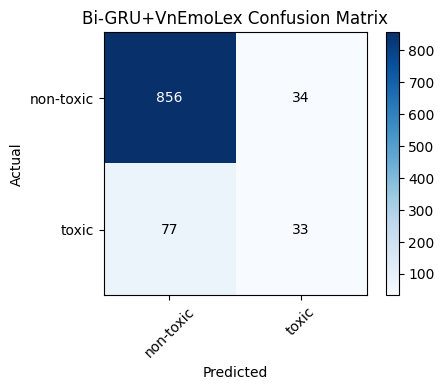

In [ ]:
def eval_and_report_softmax(model, X_seq, LX, y_true, name, thres=0.5):
    y_pred_prob = model.predict([X_seq, LX], verbose=0)
    y_pred = (y_pred_prob[:, 1] >= thres).astype(int)
    acc     = accuracy_score(y_true, y_pred)
    p_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    r_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f_micro = f1_score(y_true, y_pred, average='micro')
    f_macro = f1_score(y_true, y_pred, average='macro')
    print(f"\n--- {name} on Test ---")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision-Macro: {p_macro:.4f}")
    print(f"Recall-Macro   : {r_macro:.4f}")
    print(f"F1-Micro       : {f_micro:.4f}")
    print(f"F1-Macro       : {f_macro:.4f}\n")
    print(classification_report(y_true, y_pred, digits=4))
    labels = [0, 1]
    ticks  = ['non-toxic', 'toxic']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5, 4))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f"{name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, ticks, rotation=45)
    plt.yticks(tick_marks, ticks)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color=color)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

eval_and_report_softmax(gru_lex, X_test_gru, LX_test, Y_test, 'Bi-GRU+VnEmoLex', thres=0.5)